# Funkcje Pomocnicze do Zadania

Aby wszystkie funkcje zadziałały, notebook powinien być uruchamiany z następującym ułożeniem katalogów:

```
|- helpers.ipynb
|- sampleSubmission.csv
|- train
 |- {unzipped train files and labels}
|- test
 |- {unzipped test files}
```

Należy odkomentować u siebie linijki zapisujące pliki.

In [2]:
import os

import librosa
from scipy import signal
from scipy.io import wavfile
from sklearn.metrics import roc_auc_score
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm, trange

SEED = 20124
torch.manual_seed(SEED)
np.random.seed(SEED)

# Wczytywanie Danych

Poniższe funkcje są przykładowymi funkcjami wczytującymi dane. Możliwe, że będą potrzebne modyfikacje reprezentacji i bardziej skomplikowana funkcja tworząca zbiór treningowy. Wczytywanie danych nie jest zaimplementowane optymalnie - między innymi kod wczytuje wielokrotnie ten sam plik. Dla bardziej złożonych reprezentacji możliwe, że trzeba będzie przepisać te funkcje.

In [3]:
def load_mel(file_name, start=0, stop=None, n_mels=60):
    '''Wczytuje mel spektrogram z pliku.
    
    Args:
        file_name (str): Nazwa pliku z nagraniem.
        start (float): Sekunda, w której zaczyna się interesujący fragment.
        stop (float): Sekunda, w której kończy się interesujący fragment.
        n_mels (int): Liczba meli na spektrogramie (wysokość spektrogramu).
    
    Returns:
        ndarray: Spektrogram.
    '''
    samples, sample_rate = librosa.core.load(file_name, sr = None)
    samples = samples[int(start * sample_rate):int(stop * sample_rate) if stop else None]
    spectrogram = librosa.feature.melspectrogram(y = samples, sr = sample_rate,
                                                 n_mels = n_mels, fmin = 4000, fmax = 9500)
    return spectrogram


def load_spec(file_name, start=0, stop=None):
    '''Wczytuje standardowy spektrogram z pliku.
    
    Args:
        file_name (str): Nazwa pliku z nagraniem.
        start (float): Sekunda, w której zaczyna się interesujący fragment.
        stop (float): Sekunda, w której kończy się interesujący fragment.
    
    Returns:
        ndarray: Spektrogram.
    '''
    sample_rate, samples = wavfile.read(file_name)
    samples = samples[int(start * sample_rate):int(stop * sample_rate) if stop else None]
    _, _, spectrogram = signal.spectrogram(samples, sample_rate)
    return spectrogram


def load_test(load_repr=load_mel):
    '''Wczytuje dane testowe.
    
    Args:
        load_repr (function): Funkcja wczytująca pożądaną reprezentację.
    
    Returns:
        ndarray: Tablica z danymi testowymi.
    '''
    with open('sampleSubmission.csv', 'r') as file:
        lines = file.read().split()[1:]
        sample_ids = [line.split(',')[0] for line in lines]
        samples = np.array([s.split('/') for s in sample_ids])
    
    X_test = []
    rec_files = sorted([file_name for file_name in os.listdir('test') 
                        if file_name.endswith('.wav')], key=lambda x: int(x.split('.')[0][3:]))
    for file_name in rec_files:
        recording_id = file_name.split('.')[0][3:]
        time_markers = samples[samples[:, 0] == recording_id, 1].astype(np.int)
        for t in time_markers:
            representation = load_repr(os.path.join('test', file_name), start = t, stop = t + 1)
            X_test.append(representation)
    return np.array(X_test)


def read_labels():
    '''Wczytuje etykiety czasowe z pliku labels.txt w folderze train.
    
    Returns:
        ndarray: Tablica z etykietami czasowymi zawierająca kolumny: nr nagrania, sekunda początku dźwięku, sekunda końca dźwięku.
    '''
    labels = []
    with open(os.path.join('train', 'labels.txt'), 'r') as file:
        text = file.read()
        for line in text.split('\n')[1:]:
            if len(line) > 1:
                rec, start, stop = line.split(',')
                rec, start, stop = int(rec[3:]), float(start), float(stop)
                labels.append([rec, start, stop])
    return np.array(labels)


def check_voices(second, labels, tol=0.):
    '''Sprawdza czy w ramce czasowej [second, second+1] znajduje się głos według etykiet `labels`.
    
    Args:
        second (float): Sekunda nagrania.
        labels (ndarray): Tablica z etykietami, której 2 kolumna oznacza początek, a 3-cia - koniec nagrania.
        tol (float): Tolerancja na brzegach fragmentu. Dźwięk, żeby był uznany, musi się kończyć po czasie `second+tol`
            lub zaczynać przed czasem `second+1-tol`.
    Returns:
        bool: Czy w ramce czasowej jest odgłos ptaka.
    '''
    return (labels[1] >= second and labels[1] < second + 1 - tol) or \
           (labels[2] < second + 1 and labels[2] > second + tol) or \
           (labels[1] < second and labels[2] > second + 1)


def map_seconds_to_y(labels):
    '''Tworzy etykiety dla każdej kolejnej sekundy 10-sekundowego nagrania. -1 oznacza niepewną etykietę (urwane dźwięki na brzegach).
    
    Args:
        labels (ndarray): Tablica z etykietami, której 2 kolumna oznacza początek, a 3-cia - koniec nagrania.
    Returns:
        ndarray: Tablica z binarnymi etykietami dla każdej z 10 sekund z możliwą niepewną etkietą -1.
    '''
    y = [0] * 10
    y_restrictive = [0] * 10
    for s in range(10):
        for l in labels:
            if check_voices(s, l):
                y[s] = 1
            if check_voices(s, l, 0.02):
                y_restrictive[s] = 1
        if y[s] != y_restrictive[s]:
            y[s] = -1
    return y


def load_train(load_repr=load_mel):
    '''Wczytuje dane treningowe.
    
    Args:
        load_repr (function): Funkcja wczytująca pożądaną reprezentację.
    
    Returns:
        (ndarray, ndarray): Tablica z danymi treningowymi, tablica z binarnymi etykietami treningowymi.
    '''
    labels = read_labels()
    X_train, y_train = [], []
    rec_files = sorted([file_name for file_name in os.listdir('train') if file_name.endswith('.wav')])
    for file_name in rec_files:
        recording_id = int(file_name.split('.')[0][3:])
        recording_labels = labels[labels[:, 0] == recording_id]
        y_binary = map_seconds_to_y(recording_labels)
        for i, y in enumerate(y_binary):
            if y != -1:
                try:
                    representation = load_repr(os.path.join('train', file_name), start = i, stop = i + 1)
                    X_train.append(representation)
                    y_train.append(y)
                except ValueError:
                    print('Error reading file', file_name)
                except TypeError:
                    print('Unsupported type', file_name)
    return np.array(X_train), np.array(y_train)

# Zapisywanie Wczytanej Reprezentacji

Ponieważ tworzenie reprezentacji może zabierać sporo czasu (szczególnie w tak naiwnej implementacji jak powyższa), warto zapisać wczytane dane do plików.

In [4]:
X_test = load_test()
np.save(os.path.join('test', 'tmp_X_test'), X_test)

X, y = load_train()
np.save(os.path.join('train', 'tmp_X_train'), X)
np.save(os.path.join('train', 'tmp_y_train'), y)

# Model i Trenowanie

Poniższy przykład używa poprawnych metryk i zapisuje parametry modelu.

In [6]:
class BirdDetector(torch.nn.Module):
    
    def __init__(self):
        super(BirdDetector, self).__init__()
        self.pool = torch.nn.MaxPool2d(2)
        
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=96, kernel_size=5, padding=2)
        self.bn1 = torch.nn.BatchNorm2d(96)
        
        self.conv2 = torch.nn.Conv2d(in_channels=96, out_channels=64, kernel_size=5, padding=2)
        self.bn2 = torch.nn.BatchNorm2d(64)
        
        self.conv3 = torch.nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1)
        self.bn3 = torch.nn.BatchNorm2d(32)
        
        self.fc1 = torch.nn.Linear(2240, 500) #128*15*2
        self.fc2 = torch.nn.Linear(500, 2)
        
        self.sigmoid = torch.nn.Sigmoid()
            
    def forward(self, x):
        
        out = self.pool(self.bn1(torch.relu(self.conv1(x))))
        out = self.pool(self.bn2(torch.relu(self.conv2(out))))
        out = self.pool(self.bn3(torch.relu(self.conv3(out))))
        
        out = out.view(out.size(0), -1)
        
        out = self.fc1(out)
        out = self.fc2(out)
        
        return self.sigmoid(out)
    
model = BirdDetector()

In [7]:
# Dzielenie zbioru danych na treningowy i walidacyjny
split_point = int(len(X) * 0.8)

X_train = torch.Tensor(X[:split_point])
y_train = torch.LongTensor(y[:split_point])

X_valid = torch.Tensor(X[split_point:])
y_valid = torch.LongTensor(y[split_point:])

batch_size = 64

dataset = TensorDataset(X_train, y_train)
data_loader = DataLoader(dataset, batch_size = batch_size, shuffle = True)

valid_dataset = TensorDataset(X_valid, y_valid)
valid_data_loader = DataLoader(valid_dataset, batch_size = batch_size)

In [8]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), amsgrad=True)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, verbose=True)

best_preds, best_score = None, 0.
losses, scores = [], []
for epoch in trange(50):
    running_loss = 0
    model.train()
    for x, y in data_loader:
        optimizer.zero_grad()

        outputs = model(x.view(-1, 1, x.shape[1], x.shape[2]))
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    losses.append(running_loss)
    
    model.eval()
    preds = []
    for x, _ in valid_data_loader:
        out = model(x.view(-1, 1, x.shape[1], x.shape[2]))
        preds.append(torch.softmax(out, dim = 1)[:, 1].detach().numpy())
    preds = np.concatenate(preds, axis = 0)
    
    score = roc_auc_score(y_valid.numpy(), preds)
    scores.append(score)
    print(f"Epoch: {epoch}, ROC AUC score: {score}")
    if score > best_score:
        best_score = score
        best_preds = preds
        np.save('tmp_preds', best_preds)
        torch.save(model.state_dict(), 'tmp_model.pt')
    scheduler.step(loss)

  2%|▏         | 1/50 [02:08<1:45:12, 128.83s/it]

Epoch: 0, ROC AUC score: 0.5


  4%|▍         | 2/50 [04:01<1:39:08, 123.92s/it]

Epoch: 1, ROC AUC score: 0.5841656698564592


  6%|▌         | 3/50 [05:54<1:34:28, 120.61s/it]

Epoch: 2, ROC AUC score: 0.7701555023923445


  8%|▊         | 4/50 [07:55<1:32:42, 120.91s/it]

Epoch: 3, ROC AUC score: 0.5136363636363637


 10%|█         | 5/50 [09:52<1:29:44, 119.66s/it]

Epoch: 4, ROC AUC score: 0.5136363636363637


 12%|█▏        | 6/50 [11:52<1:27:46, 119.69s/it]

Epoch: 5, ROC AUC score: 0.5181818181818182


 14%|█▍        | 7/50 [26:27<4:08:13, 346.36s/it]

Epoch: 6, ROC AUC score: 0.5


 16%|█▌        | 8/50 [39:12<5:30:25, 472.04s/it]

Epoch: 7, ROC AUC score: 0.5


 18%|█▊        | 9/50 [52:18<6:26:47, 566.03s/it]

Epoch: 8, ROC AUC score: 0.5


 20%|██        | 10/50 [1:01:55<6:19:34, 569.36s/it]

Epoch: 9, ROC AUC score: 0.5136363636363637


 22%|██▏       | 11/50 [1:04:00<4:43:34, 436.26s/it]

Epoch: 10, ROC AUC score: 0.7076255980861244


 24%|██▍       | 12/50 [1:06:06<3:37:18, 343.11s/it]

Epoch: 11, ROC AUC score: 0.734696471291866
Epoch    11: reducing learning rate of group 0 to 1.0000e-04.


 26%|██▌       | 13/50 [1:08:17<2:52:16, 279.37s/it]

Epoch: 12, ROC AUC score: 0.5681818181818181


 28%|██▊       | 14/50 [1:10:30<2:21:12, 235.35s/it]

Epoch: 13, ROC AUC score: 0.6090909090909091


 30%|███       | 15/50 [1:12:45<1:59:52, 205.51s/it]

Epoch: 14, ROC AUC score: 0.7071994617224879


 32%|███▏      | 16/50 [1:14:54<1:43:25, 182.52s/it]

Epoch: 15, ROC AUC score: 0.7359674043062201


 34%|███▍      | 17/50 [1:16:59<1:30:50, 165.17s/it]

Epoch: 16, ROC AUC score: 0.7350179425837322


 36%|███▌      | 18/50 [1:18:55<1:20:14, 150.47s/it]

Epoch: 17, ROC AUC score: 0.7336124401913876


 38%|███▊      | 19/50 [1:20:51<1:12:24, 140.15s/it]

Epoch: 18, ROC AUC score: 0.7410436602870814


 40%|████      | 20/50 [1:22:47<1:06:28, 132.94s/it]

Epoch: 19, ROC AUC score: 0.7463965311004784


 42%|████▏     | 21/50 [1:24:44<1:01:53, 128.05s/it]

Epoch: 20, ROC AUC score: 0.7530726674641148


 44%|████▍     | 22/50 [1:26:40<58:04, 124.43s/it]  

Epoch: 21, ROC AUC score: 0.777840909090909


 46%|████▌     | 23/50 [1:28:36<54:50, 121.86s/it]

Epoch: 22, ROC AUC score: 0.7544183612440191


 48%|████▊     | 24/50 [1:30:32<52:02, 120.08s/it]

Epoch: 23, ROC AUC score: 0.7641447368421053
Epoch    23: reducing learning rate of group 0 to 1.0000e-05.


 50%|█████     | 25/50 [1:32:27<49:28, 118.75s/it]

Epoch: 24, ROC AUC score: 0.7651540071770335


 52%|█████▏    | 26/50 [1:34:23<47:07, 117.80s/it]

Epoch: 25, ROC AUC score: 0.7747532894736843


 54%|█████▍    | 27/50 [1:36:19<44:55, 117.18s/it]

Epoch: 26, ROC AUC score: 0.7801958732057415


 56%|█████▌    | 28/50 [1:38:14<42:48, 116.73s/it]

Epoch: 27, ROC AUC score: 0.779941686602871


 58%|█████▊    | 29/50 [1:40:10<40:42, 116.33s/it]

Epoch: 28, ROC AUC score: 0.7858403110047847


 60%|██████    | 30/50 [1:42:05<38:39, 115.97s/it]

Epoch: 29, ROC AUC score: 0.7737739234449761


 62%|██████▏   | 31/50 [1:44:00<36:39, 115.76s/it]

Epoch: 30, ROC AUC score: 0.7744318181818182


 64%|██████▍   | 32/50 [1:45:55<34:39, 115.52s/it]

Epoch: 31, ROC AUC score: 0.7751569976076556


 66%|██████▌   | 33/50 [1:47:50<32:41, 115.38s/it]

Epoch: 32, ROC AUC score: 0.7826405502392345


 68%|██████▊   | 34/50 [1:49:45<30:43, 115.21s/it]

Epoch: 33, ROC AUC score: 0.7795903110047846


 70%|███████   | 35/50 [1:51:40<28:47, 115.14s/it]

Epoch: 34, ROC AUC score: 0.77970245215311


 72%|███████▏  | 36/50 [1:53:34<26:49, 114.95s/it]

Epoch: 35, ROC AUC score: 0.7811976674641149
Epoch    35: reducing learning rate of group 0 to 1.0000e-06.


 74%|███████▍  | 37/50 [1:55:29<24:52, 114.84s/it]

Epoch: 36, ROC AUC score: 0.7800538277511961


 76%|███████▌  | 38/50 [1:57:24<22:57, 114.77s/it]

Epoch: 37, ROC AUC score: 0.7807416267942584


 78%|███████▊  | 39/50 [1:59:19<21:02, 114.80s/it]

Epoch: 38, ROC AUC score: 0.7800837320574162


 80%|████████  | 40/50 [2:01:13<19:07, 114.74s/it]

Epoch: 39, ROC AUC score: 0.7725328947368422


 82%|████████▏ | 41/50 [2:03:08<17:12, 114.72s/it]

Epoch: 40, ROC AUC score: 0.7745065789473684


 84%|████████▍ | 42/50 [2:05:02<15:17, 114.63s/it]

Epoch: 41, ROC AUC score: 0.7791193181818181


 86%|████████▌ | 43/50 [2:06:57<13:23, 114.72s/it]

Epoch: 42, ROC AUC score: 0.7801883971291865


 88%|████████▊ | 44/50 [2:08:52<11:27, 114.66s/it]

Epoch: 43, ROC AUC score: 0.77816985645933


 90%|█████████ | 45/50 [2:10:46<09:33, 114.64s/it]

Epoch: 44, ROC AUC score: 0.7847039473684211


 92%|█████████▏| 46/50 [2:12:41<07:38, 114.58s/it]

Epoch: 45, ROC AUC score: 0.7782446172248804


 94%|█████████▍| 47/50 [2:14:35<05:43, 114.58s/it]

Epoch: 46, ROC AUC score: 0.7828797846889952
Epoch    46: reducing learning rate of group 0 to 1.0000e-07.


 96%|█████████▌| 48/50 [2:16:30<03:49, 114.55s/it]

Epoch: 47, ROC AUC score: 0.7783193779904305


 98%|█████████▊| 49/50 [2:18:24<01:54, 114.57s/it]

Epoch: 48, ROC AUC score: 0.7838591507177033


100%|██████████| 50/50 [2:20:19<00:00, 114.56s/it]

Epoch: 49, ROC AUC score: 0.7802631578947369


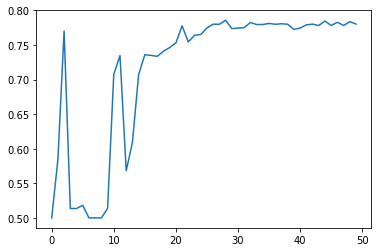

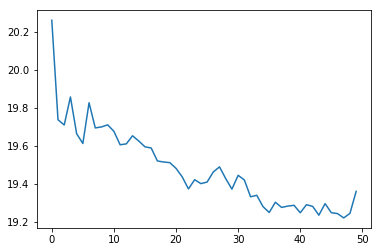

In [10]:
import matplotlib.pyplot as plt

%matplotlib inline

plt.plot(scores)
plt.show()

plt.plot(losses)
plt.show()

# Zapis Predykcji

In [11]:
def save_predictions(preds):
    '''Zapisuje predykcje do pliku zgodnego z formatem odpowiedzi.
    
    Args:
        preds (list): Lista predykcji (prawdopodobieństw).
    '''
    with open('sampleSubmission.csv', 'r') as file:
        submission_text = file.read().split()
        header = submission_text[0]
        lines = submission_text[1:]

    output_lines = [header]
    for pred, line in zip(preds, lines):
        output_lines.append("{},{}".format(line.split(',')[0], pred))
    
    with open('mySubmission.csv', 'w') as file:
        file.write('\n'.join(output_lines) + '\n')

In [12]:
model.load_state_dict(torch.load('tmp_model.pt'))

X_test_tensor = torch.Tensor(X_test)

test_dataset = TensorDataset(X_test_tensor)
test_data_loader = DataLoader(test_dataset, batch_size = batch_size)

model.eval()
preds = []
for x in test_data_loader:
    out = model(x[0].view(-1, 1, x[0].shape[1], x[0].shape[2]))
    preds.append(torch.softmax(out, dim = 1)[:, 1].detach().numpy())
preds = np.concatenate(preds, axis = 0)

save_predictions(preds)